## Imports


In [1]:
import os
import numpy as np
from numpy.lib.npyio import load
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
from typing import List, NoReturn
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow._api.v2 import data
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



## Configure GPU and CUDA


In [2]:
config = tf.compat.v1.ConfigProto(gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
config


gpu_options {
  per_process_gpu_memory_fraction: 0.8
  allow_growth: true
}

## Helper methods


In [3]:
def loadData(path:str, labels:list, imgSize:tuple, validationSubset:bool=False) -> tf.data.Dataset:
    batch_size = 32
    subset = "validation" if validationSubset else "training"

    return tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels=labels,
        color_mode="grayscale",
        image_size=imgSize,
        batch_size=batch_size,
        validation_split=0.2,
        subset=subset,
        seed=123
    )

def loadTestData(path:str, labels:list, imgSize:tuple) -> tf.data.Dataset:
    batch_size = 32
    return tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels=labels,
        color_mode="grayscale",
        image_size=imgSize,
        batch_size=batch_size,
    )

def plotObjectWithKeypoints(dataSet:tf.data.Dataset, number:int, imageSize:int) -> None:
    plt.figure(figsize=(15,15))
    for images, labels in dataSet.take(1):
        for i in range(number):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(tf.keras.preprocessing.image.array_to_img(images[i]))
            plt.scatter(labels[i][0::2]*imageSize, labels[i][1::2]*imageSize, marker='x', s=40, c='red')
            plt.axis("off")

def plotTrainingHistory(history:tf.keras.callbacks.History, metric:str) -> None:
    loss = history.history[metric]
    val_loss = history.history['val_{}'.format(metric)]

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.plot(epochs_range, loss, label='Training {}'.format(metric))
    plt.plot(epochs_range, val_loss, label='Validation {}'.format(metric))
    plt.legend(loc='upper right')
    plt.title('Training and Validation {}'.format(metric))
    plt.show()


## Load datasets


In [4]:
imageH = 120
imageW = 120
numFeatures = 16

dsTrain = loadData(path='resources/drill/train',
            labels=list(np.load('resources/drill/drill_keypoints_train.npy').reshape(294,16)),
            imgSize=(imageH,imageW),
            validationSubset=False)

dsValid = loadData(path='resources/drill/train',
                    labels=list(np.load('resources/drill/drill_keypoints_train.npy').reshape(294,16)),
                    imgSize=(imageH,imageW),
                    validationSubset=True)

dsTest = loadTestData(path='resources/drill/test',
                    labels=list(np.load('resources/drill/drill_keypoints_test.npy').reshape(66,16)),
                    imgSize=(imageH,imageW))



Found 294 files belonging to 1 classes.
Using 236 files for training.
Found 294 files belonging to 1 classes.
Using 58 files for validation.
Found 66 files belonging to 1 classes.


## Configure performance

 ```
 data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
 ])
 .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE) \
 ```

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

dsTrain = dsTrain.cache().shuffle(300) \
    .prefetch(buffer_size=AUTOTUNE)

dsValid = dsValid.cache() \
    .prefetch(buffer_size=AUTOTUNE)



## Create basic model


In [6]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(imageH, imageW, 1)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(numFeatures)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 120, 120, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 120, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0

## Train the model


In [7]:
epochs = 20
history = model.fit(dsTrain,
                validation_data=dsValid,
                epochs=epochs)


Epoch 1/20
8/8 [==============================] - 5s 200ms/step - loss: 0.1380 - accuracy: 0.1320 - val_loss: 0.0176 - val_accuracy: 0.2586
Epoch 2/20
8/8 [==============================] - 0s 14ms/step - loss: 0.0149 - accuracy: 0.3130 - val_loss: 0.0087 - val_accuracy: 0.6724
Epoch 3/20
8/8 [==============================] - 0s 14ms/step - loss: 0.0080 - accuracy: 0.5368 - val_loss: 0.0065 - val_accuracy: 0.5517
Epoch 4/20
8/8 [==============================] - 0s 14ms/step - loss: 0.0058 - accuracy: 0.5343 - val_loss: 0.0047 - val_accuracy: 0.7414
Epoch 5/20
8/8 [==============================] - 0s 14ms/step - loss: 0.0038 - accuracy: 0.6318 - val_loss: 0.0038 - val_accuracy: 0.7241
Epoch 6/20
8/8 [==============================] - 0s 14ms/step - loss: 0.0029 - accuracy: 0.5794 - val_loss: 0.0028 - val_accuracy: 0.6897
Epoch 7/20
8/8 [==============================] - 0s 14ms/step - loss: 0.0025 - accuracy: 0.5991 - val_loss: 0.0024 - val_accuracy: 0.8103
Epoch 8/20
8/8 [==========

## Inspect training accuracy


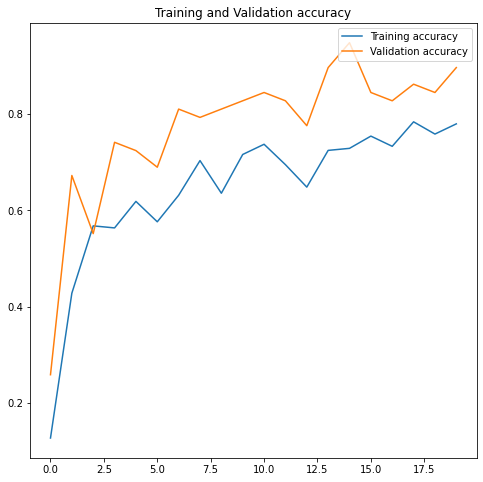

In [8]:
plotTrainingHistory(history, metric='accuracy')



## Predict on test data and plot


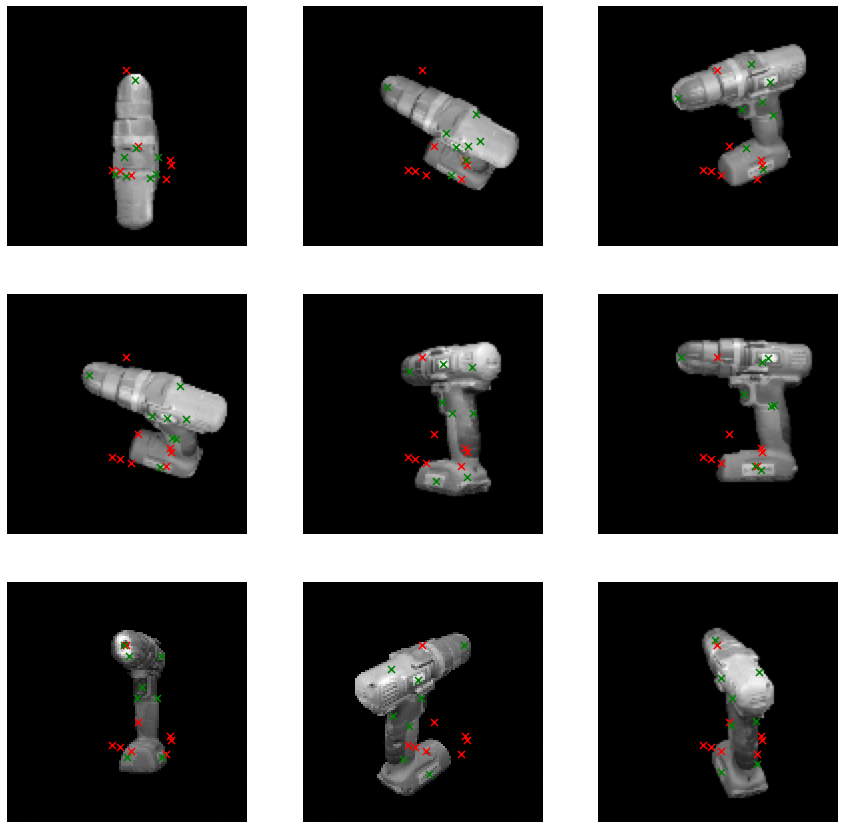

In [9]:
y = model.predict(dsTest)

plt.figure(figsize=(15,15))
for (images, labels), predLabel in zip(dsTest.take(1), y):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(images[i]), cmap='gray')
        plt.scatter(predLabel[0::2]*120, predLabel[1::2]*120, marker='x', s=50, c='red')
        plt.scatter(labels[i][0::2]*120, labels[i][1::2]*120, marker='x', s=50, c='green')
        plt.axis("off")


## Score model


In [10]:
test_loss, test_acc = model.evaluate(dsTest, verbose=2)


3/3 - 0s - loss: 7.5178e-04 - accuracy: 0.8485
